In [109]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline

In [5]:
def load_cv_vid(filepath: str) -> cv2.VideoCapture:
    return cv2.VideoCapture(filepath)

cap_out = load_cv_vid("mine_shortened_no_crop.mp4")

In [3]:
# Define the lower and upper bounds of the blue color
# LOWER_BLUE = np.array([100, 150, 0])
# UPPER_BLUE = np.array([140, 255, 255])
LOWER_BLUE = np.array([90, 50, 50])
UPPER_BLUE = np.array([130, 255, 255])

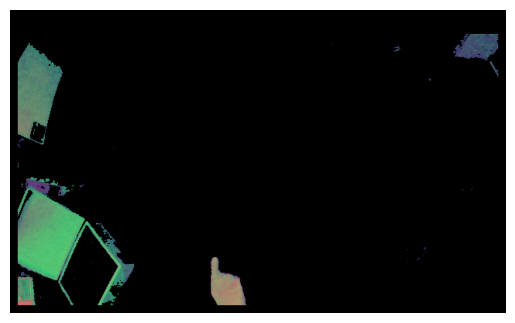

Number of Blue Pixels: 18297


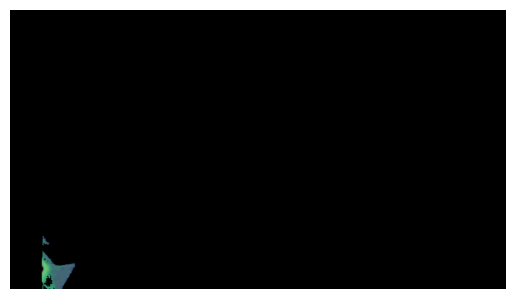

Number of Blue Pixels: 4740


In [8]:
def mask_image(image: np.ndarray):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image_mask = cv2.inRange(hsv_image, LOWER_BLUE, UPPER_BLUE)
    # apply mask to image
    color_image = cv2.bitwise_and(hsv_image, hsv_image, mask=hsv_image_mask)
    # Display the color image using Matplotlib
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    num_blue_pixels = cv2.countNonZero(hsv_image_mask)

    print("Number of Blue Pixels:", num_blue_pixels)
    
mask_image(cv2.imread("media/glove_frame.png")) # non-glove_frame
mask_image(cv2.imread("media/non-glove_frame.png"))

In [122]:
import cv2
import numpy as np

def count_blue_pixels_in_video(cap: cv2.VideoCapture, lower_blue: np.ndarray, upper_blue: np.ndarray) -> np.ndarray:
    """
    Counts the number of blue pixels in each frame of a video.

    Args:
        cap (cv2.VideoCapture): The video capture object.
        lower_blue (np.ndarray): The lower bound of the blue color in HSV.
        upper_blue (np.ndarray): The upper bound of the blue color in HSV.

    Returns:
        np.ndarray: A 1D array containing the count of blue pixels for each frame.
        
    Raises:
        IOError
    """
    
    # Check if the video capture object is opened successfully
    if not cap.isOpened():
        raise ValueError("Video file not opened")
    
    # Initialize an empty list to store the count of blue pixels for each frame
    blue_pixel_counts = []
    
    # Loop through the video frames
    while True:
        # Read the next frame from the video
        ret, frame = cap.read()
        
        # If the frame was not grabbed, then we have reached the end of the video
        if not ret:
            break
        
        # Convert the frame to HSV color space
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Create a binary mask for the blue color
        blue_mask = cv2.inRange(hsv_frame, lower_blue, upper_blue)
        
        # Count the number of non-zero pixels in the mask (blue pixels in the original frame)
        num_blue_pixels = cv2.countNonZero(blue_mask)
        
        # Append the count to the list
        blue_pixel_counts.append(num_blue_pixels)
    
    # Release the video capture object
    cap.release()
    
    # Convert the list of blue pixel counts to a 1D NumPy array and return it
    return np.array(blue_pixel_counts)

# Define the lower and upper bounds of the blue color in HSV
LOWER_BLUE = np.array([100, 150, 0])
UPPER_BLUE = np.array([140, 255, 255])

cap_out2 = cv2.VideoCapture("20_sec_crop.mp4")
# cap_out2 = cv2.VideoCapture("whole_thing_cropped.mp4")

blue_pixel_counts = count_blue_pixels_in_video(cap = cap_out2, lower_blue=LOWER_BLUE, upper_blue=UPPER_BLUE)
cap_out2.release()

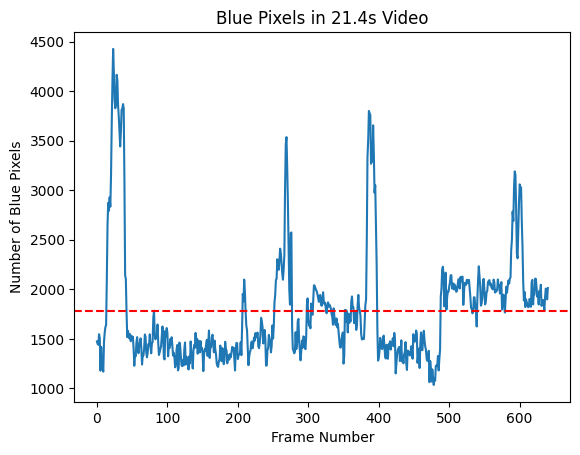

In [123]:
fig, ax = plt.subplots(1, 1)
ax.plot(blue_pixel_counts)
ax.set_xlabel("Frame Number")
ax.set_ylabel("Number of Blue Pixels")
ax.set_title(f"Blue Pixels in {len(blue_pixel_counts)/29.97:.1f}s Video")

# Calculate the average
average_value = np.mean(blue_pixel_counts)

# Add a red horizontal line at the average value
ax.axhline(y=average_value, color='red', linestyle='--', label='Average')

plt.show()


In [124]:
def plotly_pixel_counts(pixel_counts):
    # Create a Plotly figure
    fig = go.Figure()

    # Add a trace for the blue pixel counts
    fig.add_trace(go.Scatter(x=np.arange(len(pixel_counts)),
                             y=pixel_counts,
                             mode='lines',
                             name='Number of Blue Pixels'))

    # Customize the layout
    fig.update_layout(
        xaxis_title="Frame Number",
        yaxis_title="Number of Blue Pixels",
        title=f"Blue Pixels in {len(pixel_counts)/29.97:.1f}s Video"
    )

    # Enable zooming and panning
    fig.update_xaxes(type='linear')
    fig.update_yaxes(type='linear')

    # Display the interactive plot
    fig.show()


plotly_pixel_counts(blue_pixel_counts)

In [107]:
def local_max_avg_threshold(arr, avg_multiple: float = 1.5, padding: int = 15):
    """
    Find the indices of maximum values in intervals that exceed a specified multiple of the average value.

    Args:
        arr (numpy.ndarray): The input NumPy array containing the data.
        avg_multiple (float, optional): The multiple of the average value used as the threshold. Default is 1.5.
        padding (int, optional): The number of elements to consider as padding. If a new maximum is found
            within this range of a previous maximum, it will not be counted. Default is 0.

    Returns:
        np.ndarray: An array containing the indices of maximum values within intervals exceeding the threshold.
    """

    # Calculate the threshold as a multiple of the average
    threshold = avg_multiple * np.mean(arr)
    
    # Initialize variables to keep track of intervals
    start = None
    max_indices = []
    
    for i, value in enumerate(arr):
        if value > threshold:
            if start is None:
                start = i
            elif i == len(arr) - 1:
                # Handle the case when the interval extends to the end of the array
                end = i
                interval = arr[start:end + 1]
                max_index = start + np.argmax(interval)
                if not max_indices or max_index - max_indices[-1] > padding:
                    max_indices.append(max_index)
        elif start is not None:
            end = i - 1
            interval = arr[start:end + 1]
            max_index = start + np.argmax(interval)
            if not max_indices or max_index - max_indices[-1] > padding:
                max_indices.append(max_index)
            start = None
    
    return np.array(max_indices)

Max indices in intervals exceeding 1.5 times the average: [ 23 269 386 593]


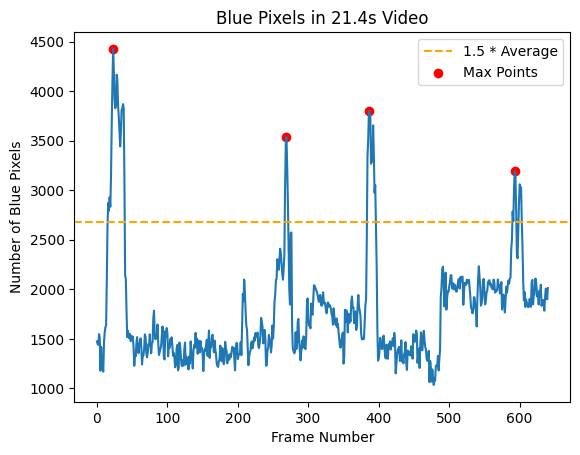

[ 23 269 386 593]


In [125]:
max_indices = local_max_avg_threshold(blue_pixel_counts, padding=15)
# max_indices = find_max_indices_above_threshold1(blue_pixel_counts)
print("Max indices in intervals exceeding 1.5 times the average:", max_indices)
fig, ax = plt.subplots(1, 1)
ax.plot(blue_pixel_counts)
ax.set_xlabel("Frame Number")
ax.set_ylabel("Number of Blue Pixels")
ax.set_title(f"Blue Pixels in {len(blue_pixel_counts)/29.97:.1f}s Video")

# Calculate the average
average_value = np.mean(blue_pixel_counts)

# Add a red horizontal line at the average value
ax.axhline(y=average_value * 1.5, color='orange', linestyle='--', label='1.5 * Average')
ax.scatter(max_indices, blue_pixel_counts[max_indices], c='red', marker='o', label='Max Points')

plt.legend()
plt.show()

print(max_indices)

In [126]:
def plotly_with_max(y: np.ndarray, max_indices: np.ndarray) -> None:
    fig = go.Figure()
    
    # Calculate the time in seconds for each index
    time_seconds = np.arange(len(y)) / 29.97
    
    # Add a line trace for blue_pixel_counts
    fig.add_trace(go.Scatter(x=time_seconds, y=y, mode='lines', name='Blue Pixels'))
    
    # Add a horizontal line at the threshold
    fig.add_shape(type='line',
                  x0=0,
                  x1=max(time_seconds),
                  y0=np.mean(y) * 1.5,
                  y1=np.mean(y) * 1.5,
                  line=dict(color='orange', dash='dash'),
                  name='1.5 * Average')
    
    # Create a list of labels for hover text
    hover_labels = [f"Index: {idx}, Seconds: {time:.2f}" for idx, time in zip(max_indices, time_seconds[max_indices])]
    
    # Add red bullet points at the max indices with hover text
    fig.add_trace(go.Scatter(x=time_seconds[max_indices], y=y[max_indices],
                             mode='markers',
                             marker=dict(color='red', size=8),
                             name='Max Points',
                             text=hover_labels,  # Set hover text
                             hoverinfo='text'  # Show text on hover
                            ))
    
    # Customize layout
    fig.update_layout(title=f"Blue Pixels in {len(y)/29.97:.1f}s Video",
                      xaxis_title="Time (Seconds)",
                      yaxis_title="Number of Blue Pixels",
                      legend=dict(x=1, y=0),
                      showlegend=True)
    
    # Show the plot
    fig.show()

plotly_with_max(blue_pixel_counts, max_indices)

In [127]:
def split_video(cap: cv2.VideoCapture, split_frame_indices: np.ndarray, output_dir: str = "split_clips") -> None:
    """
    Splits a video into multiple segments based on the provided split frame indices.
    
    Args:
        cap (cv2.VideoCapture): Input video file.
        split_frame_indices (np.ndarray): 1D array containing the indices of the split frames.
        output_dir (str): Directory where the split videos will be saved. Defaults to "split_clips"
        
    Returns:
        None. Video segments are saved to the specified output directory.
    """
    # Check if the video capture object is opened successfully
    if not cap.isOpened():
        raise ValueError("Video file not opened")
    
    # Get the codec information of the input video
    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))  # specifying mp4v doesn't cause warning
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    # Get characteristics of the input video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initialize the start frame index for the first segment
    start_frame_idx = 0
    
    # Iterate over the split frame indices to create video segments
    for i, split_frame_idx in enumerate(np.append(split_frame_indices, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # Define the output video path for the current segment
        output_video_path = os.path.join(output_dir, f"segment_{i + 1}.mp4")
        
        # Initialize the video writer object
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
        
        # Write frames to the output video segment
        for frame_idx in range(start_frame_idx, split_frame_idx):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        
        # Release the video writer object
        out.release()
        
        # Update the start frame index for the next segment
        start_frame_idx = split_frame_idx
    
    # Release the video capture object
    cap.release()
    print(f"Video segments have been saved to {output_dir}")

# Example usage:
# split_frame_indices = np.array([23, 269, 386, 593])  # currently manually set (every other makes it right)
split_frame_indices = max_indices
output_dir = 'output_segments_long_att1'

cap_out3 = cv2.VideoCapture("20_sec_crop.mp4")
# cap_out2 = cv2.VideoCapture("whole_thing_cropped.mp4")
split_video(cap_out3, split_frame_indices[1::2], output_dir)
cap_out3.release()



Video segments have been saved to output_segments_long_att1


# vid overlay

In [121]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

    
def overlay_graph_on_video(input_video_path, blue_pixels_array, output_video_path):
    """
    Overlays a live-updated graph showing the number of blue pixels in each frame on a video.
    
    Args:
    input_video_path (str): Path to the input video file.
    blue_pixels_array (numpy.ndarray): 1D array containing the number of blue pixels in each frame.
    output_video_path (str): Path where the output video with the overlaid graph will be saved.
    """
    cap = cv2.VideoCapture(input_video_path)
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    fig, ax = plt.subplots(figsize=(frame_width / 300, frame_height / 300), dpi=100)  # Adjust the figure size
    canvas = FigureCanvasAgg(fig)
    
    graph_width, graph_height = canvas.get_width_height()
    
    for i in range(len(blue_pixels_array)):
        ret, frame = cap.read()
        if not ret:
            break
        
        ax.plot(blue_pixels_array[max(0, i - 60):i+1], color='blue')
        ax.set_xlim(max(0, i - 60), i + 1)
        ax.set_ylim(0, blue_pixels_array.max())
        
        canvas.draw()
        graph_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        graph_img = graph_img.reshape(canvas.get_width_height()[::-1] + (3,))
        
        # Position graph at the bottom-right corner
        frame[frame_height - graph_height:, frame_width - graph_width:] = graph_img
        
        out.write(frame)
        ax.clear()
    
    cap.release()
    out.release()
    plt.close()

# Example usage:
input_video_path = 'whole_thing_cropped.mp4'
output_video_path = 'whole_thing_cropped_with_graph.mp4'

overlay_graph_on_video(input_video_path, blue_pixel_counts, output_video_path)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
/var/folders/yh/cbw5x_lj4_g_fj7lht06nbt00000gn/T/ipykernel_2189/203115298.py:81: MatplotlibDeprecationWarning:

The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.



7.972972972972974


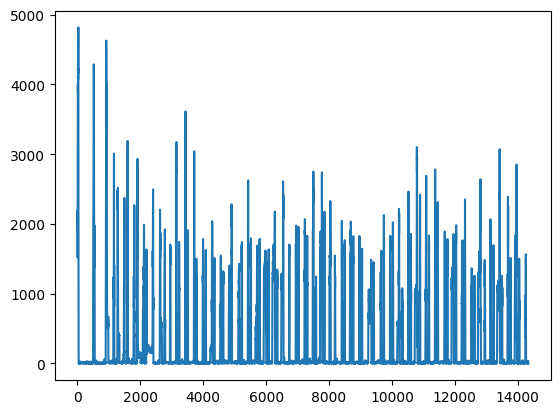

In [120]:
plt.plot(blue_pixel_counts);
print(len(blue_pixel_counts)/(29.97 * 60))
